# Using XGBoost for predicting the type of the record: signal or background

## Preparing the data for training and testing

- Load and tranform data for ML.

In [1]:
import sys
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install graphviz
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import os

In [2]:
all_data = pd.read_csv('./input/general/atlas-higgs-challenge-2014-v2.csv')
test_data = all_data[all_data['KaggleSet'] == 't']

def label_transform (row) :
    if row['Label'] == 's' : 
        return 1
    return 0

td_1 = test_data.assign(Label_N = test_data.apply(lambda row : label_transform(row), axis = 1))
td_1 = td_1.loc[:, td_1.columns != 'Label']

td_2 = td_1.loc[:, td_1.columns != 'Weight']
td_2 = td_2.loc[:, td_2.columns != 'KaggleWeight']
td_2 = td_2.loc[:, td_2.columns != 'KaggleSet']
td_2 = td_2.loc[:, td_2.columns != 'EventId']
td_transf = td_2
td_transf.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label_N
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,1
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,0
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,0


In [3]:
dummy = pd.get_dummies(td_transf['PRI_jet_num'].astype('category'))
columns = dummy.columns.astype(str).tolist()
columns = ['PRI_jet_num_' + w for w in columns]
dummy.columns = columns
td_dummy = pd.concat((td_transf, dummy), axis=1)
td_dummy.drop('PRI_jet_num', axis=1, inplace=True)
td_dummy.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label_N,PRI_jet_num_0,PRI_jet_num_1,PRI_jet_num_2,PRI_jet_num_3
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,0.444,46.062,1.24,-2.475,113.497,1,0,0,1,0
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,1.158,-999.000,-999.00,-999.000,46.226,0,0,1,0,0
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,-2.028,-999.000,-999.00,-999.000,44.251,0,0,1,0,0
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,-999.000,-999.000,-999.00,-999.000,-0.000,0,1,0,0,0
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-999.000,-999.000,-999.00,-999.000,0.000,0,1,0,0,0


- Split to train and test subsets

In [4]:
X = td_dummy.loc[:, td_dummy.columns != 'Label_N']
X.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_jet_num_0,PRI_jet_num_1,PRI_jet_num_2,PRI_jet_num_3
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2.150,0.444,46.062,1.24,-2.475,113.497,0,0,1,0
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0,1,0,0
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0,1,0,0
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1,0,0,0
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1,0,0,0


In [5]:
y = td_dummy.loc[:, td_dummy.columns == 'Label_N']
y.head()

,Label_N
0,1
1,0
2,0
3,0
4,0


In [6]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains

In [7]:
dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)

## Model training
Let's use params that were obtained by cross-validation with the help of Bayesian Optimization

In [8]:
best_params = {
              'booster' : 'gbtree',
              'max_depth' : 5,
              'gamma' : 0,
              'eta' : 0.2,
              'objective' : 'binary:logistic',
#               'nthread' : 4,
#               'silent' : True,
              'eval_metric': 'auc',
#               'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : 0.85,
              'min_child_weight' : 1,
#               'max_delta_step' : int(max_delta_step),
              'seed' : 123
              }

In [28]:
xg_model = xgb.train(params=best_params, dtrain=dmatrix_train, num_boost_round=100)

## Model prediction

In [29]:
predicts = xg_model.predict(dmatrix_test)

In [30]:
print(predicts.shape)
predicts[:5]

(50000,)


array([0.00855769, 0.82443637, 0.99663144, 0.27715322, 0.32524517],
      dtype=float32)

In [31]:
auc_score = roc_auc_score(y_test, predicts)
print(auc_score)

0.9067327613903308


In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, predicts)
roc_auc = auc(fpr, tpr)

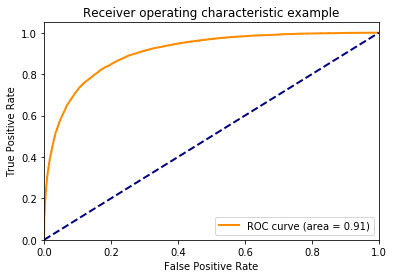

In [33]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Model with build-in missing treatment
Here we will use build-in treatment algorythm for missing values

Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains

In [92]:
dmatrix_train_miss = xgb.DMatrix(data=X_train,label=y_train, missing=-999.0)
dmatrix_test_miss = xgb.DMatrix(data=X_test,label=y_test, missing=-999.0)

## Model training
Let's use params that were obtained by cross-validation with the help of Bayesian Optimization

In [93]:
best_params_miss = {
              'booster' : 'gbtree',
              'max_depth' : 5,
              'gamma' : 0,
              'eta' : 0.2,
              'objective' : 'binary:logistic',
#               'nthread' : 4,
#               'silent' : True,
              'eval_metric': 'auc',
#               'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : 0.85,
              'min_child_weight' : 1,
#               'max_delta_step' : int(max_delta_step),
              'seed' : 123
              }

In [94]:
xg_model_miss = xgb.train(params=best_params_miss, dtrain=dmatrix_train_miss, num_boost_round=100)

## Model prediction

In [95]:
predicts_miss = xg_model_miss.predict(dmatrix_test_miss)

In [96]:
print(predicts_miss.shape)
predicts_miss[:5]

(50000,)


array([0.00843082, 0.82982165, 0.99492365, 0.20549658, 0.27853703],
      dtype=float32)

In [97]:
auc_score_miss = roc_auc_score(y_test, predicts_miss)
print(auc_score_miss)

0.906385471717113


In [98]:
fpr_miss, tpr_miss, _ = roc_curve(y_test, predicts_miss)
roc_auc = auc(fpr_miss, tpr_miss)

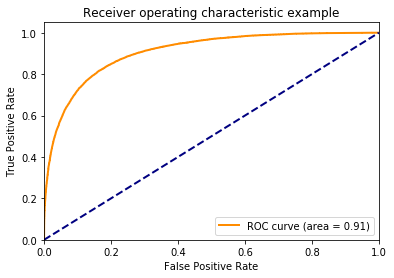

In [99]:
plt.figure()
lw = 2
plt.plot(fpr_miss, tpr_miss, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Model with special treatment for missing values

## Dataset missing values marking

In [42]:
X_with_na = X.copy()
X_with_na.replace(-999, np.nan, inplace=True)
y_with_na = y.copy()

In [43]:
X_with_na.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_jet_num_0,PRI_jet_num_1,PRI_jet_num_2,PRI_jet_num_3
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2.150,0.444,46.062,1.24,-2.475,113.497,0,0,1,0
1,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,...,0.725,1.158,NaN,NaN,NaN,46.226,0,1,0,0
2,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,...,2.053,-2.028,NaN,NaN,NaN,44.251,0,1,0,0
3,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,...,NaN,NaN,NaN,NaN,NaN,-0.000,1,0,0,0
4,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,...,NaN,NaN,NaN,NaN,NaN,0.000,1,0,0,0


In [44]:
X_train_with_na, X_test_with_na, y_train_with_na, y_test_with_na = train_test_split(X_with_na, y_with_na, test_size=0.2, random_state=123)

Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains

In [45]:
dmatrix_train_with_na = xgb.DMatrix(data=X_train_with_na,label=y_train_with_na)
dmatrix_test_with_na = xgb.DMatrix(data=X_test_with_na,label=y_test_with_na)

## Model training
Let's use params that were obtained by cross-validation with the help of Bayesian Optimization

In [46]:
best_params_with_na = {
              'booster' : 'gbtree',
              'max_depth' : 5,
              'gamma' : 0,
              'eta' : 0.2,
              'objective' : 'binary:logistic',
#               'nthread' : 4,
#               'silent' : True,
              'eval_metric': 'auc',
#               'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : 0.85,
              'min_child_weight' : 1,
#               'max_delta_step' : int(max_delta_step),
              'seed' : 123
              }

In [47]:
xg_model_with_na = xgb.train(params=best_params_with_na, dtrain=dmatrix_train_with_na, num_boost_round=100)

## Model prediction

In [80]:
predicts_with_na = xg_model_with_na.predict(dmatrix_test_with_na)

In [81]:
print(predicts_with_na.shape)
predicts_with_na[:5]

(50000,)


array([0.00843082, 0.82982165, 0.99492365, 0.20549658, 0.27853703],
      dtype=float32)

In [82]:
auc_score_with_na = roc_auc_score(y_test_with_na, predicts_with_na)
print(auc_score_with_na)

0.906385471717113


In [53]:
from sklearn.metrics import roc_curve, auc
fpr_with_na, tpr_with_na, thresholds = roc_curve(y_test_with_na, predicts_with_na)
roc_auc_with_na = auc(fpr_with_na, tpr_with_na)

In [65]:
thresholds
np.median(tpr_with_na)

0.7863981319322826

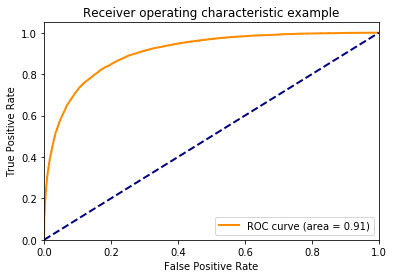

In [52]:
plt.figure()
lw = 2
plt.plot(fpr_with_na, tpr_with_na, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_with_na)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Model with weights

## Dataset additional preprocessing

In [104]:
X_weighted = X.copy()
y_weighted = y.copy()

X_weighted = X_weighted.assign(Weight = test_data.loc[:, test_data.columns == 'Weight'])
X_weighted.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_jet_num_0,PRI_jet_num_1,PRI_jet_num_2,PRI_jet_num_3,Weight
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,0.444,46.062,1.24,-2.475,113.497,0,0,1,0,0.000814
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,1.158,-999.000,-999.00,-999.000,46.226,0,1,0,0,0.681042
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,-2.028,-999.000,-999.00,-999.000,44.251,0,1,0,0,0.715742
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,-999.000,-999.000,-999.00,-999.000,-0.000,1,0,0,0,1.660654
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-999.000,-999.000,-999.00,-999.000,0.000,1,0,0,0,1.904263


In [105]:
test_data.loc[:, test_data.columns == 'Weight'].sum()

Weight    125530.319062
dtype: float64

In [106]:
X_train_weighted, X_test_weighted, y_train_weighted, y_test_weighted = train_test_split(X_weighted, y_weighted, test_size=0.2, random_state=123)

In [107]:
X_train_weighted_clean = X_train_weighted.loc[:, X_train_weighted.columns != 'Weight']
X_train_weights = X_train_weighted.loc[:, X_train_weighted.columns == 'Weight']
X_test_weighted_clean = X_test_weighted.loc[:, X_test_weighted.columns != 'Weight']
X_test_weights = X_test_weighted.loc[:, X_test_weighted.columns == 'Weight']

In [113]:
X_train_weights.values

array([[0.6397759 ],
       [0.63349955],
       [1.64212713],
       ...,
       [0.22687008],
       [0.61710986],
       [1.96209088]])

In [141]:
X_test_weighted_clean.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_jet_num_0,PRI_jet_num_1,PRI_jet_num_2,PRI_jet_num_3
5051,47.916,68.617,40.133,7.230,-999.000,-999.000,-999.000,1.657,7.230,55.139,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1,0,0,0
201568,112.799,11.484,76.882,4.016,-999.000,-999.000,-999.000,2.908,4.016,77.643,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1,0,0,0
30560,122.379,47.931,75.296,249.843,4.941,1326.936,-5.929,1.069,3.098,422.382,...,-2.890,2.151,71.231,2.052,1.883,250.243,0,0,1,0
195521,95.938,111.838,82.823,67.850,-999.000,-999.000,-999.000,1.417,39.366,184.041,...,-2.509,-2.199,-999.000,-999.000,-999.000,55.822,0,1,0,0
153551,127.450,75.047,68.447,35.886,-999.000,-999.000,-999.000,3.006,2.769,102.730,...,-0.162,-2.696,-999.000,-999.000,-999.000,33.815,0,1,0,0


Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains

In [119]:
dmatrix_train_weighted = xgb.DMatrix(data=X_train_weighted_clean, label=y_train_weighted, missing=-999.0, weight=X_train_weights.values)
dmatrix_test_weighted = xgb.DMatrix(data=X_test_weighted_clean,label=y_test_weighted, missing=-999.0, weight=X_test_weights.values)

## Model training
Let's use params that were obtained by cross-validation with the help of Bayesian Optimization

In [120]:
bst_params_weighted = {
              'booster' : 'gbtree',
              'max_depth' : 5,
              'gamma' : 0,
              'eta' : 0.2,
              'objective' : 'binary:logistic',
#               'nthread' : 4,
#               'silent' : True,
              'eval_metric': 'auc',
#               'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : 0.85,
              'min_child_weight' : 1,
#               'max_delta_step' : int(max_delta_step),
              'seed' : 123
              }

In [117]:
xg_model_weighted = xgb.train(params=bst_params_weighted, dtrain=dmatrix_train_weighted, num_boost_round=100)

## Model prediction

In [121]:
predicts_weighted = xg_model.predict(dmatrix_test_weighted)

In [122]:
print(predicts_weighted.shape)
predicts_weighted[:5]

(50000,)


array([0.00855769, 0.82443637, 0.99663144, 0.27715322, 0.32524517],
      dtype=float32)

In [123]:
auc_score_weighted = roc_auc_score(y_test_weighted, predicts_weighted)
print(auc_score_weighted)

0.9067327613903308


In [124]:
from sklearn.metrics import roc_curve, auc
fpr_weighted, tpr_weighted, _ = roc_curve(y_test_weighted, predicts_weighted)
roc_auc_weighted = auc(fpr_weighted, tpr_weighted)

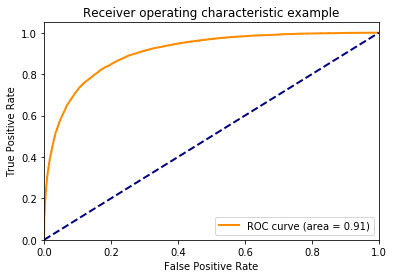

In [125]:
plt.figure()
lw = 2
plt.plot(fpr_weighted, tpr_weighted, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_with_na)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Saving model

In [136]:
xg_model_weighted.save_model('./model_weighted')

In [138]:
pickle_out = open("xg_model_weighted.pickle","wb")
pickle.dump(xg_model_weighted, pickle_out)
pickle_out.close()

# Feature Importance

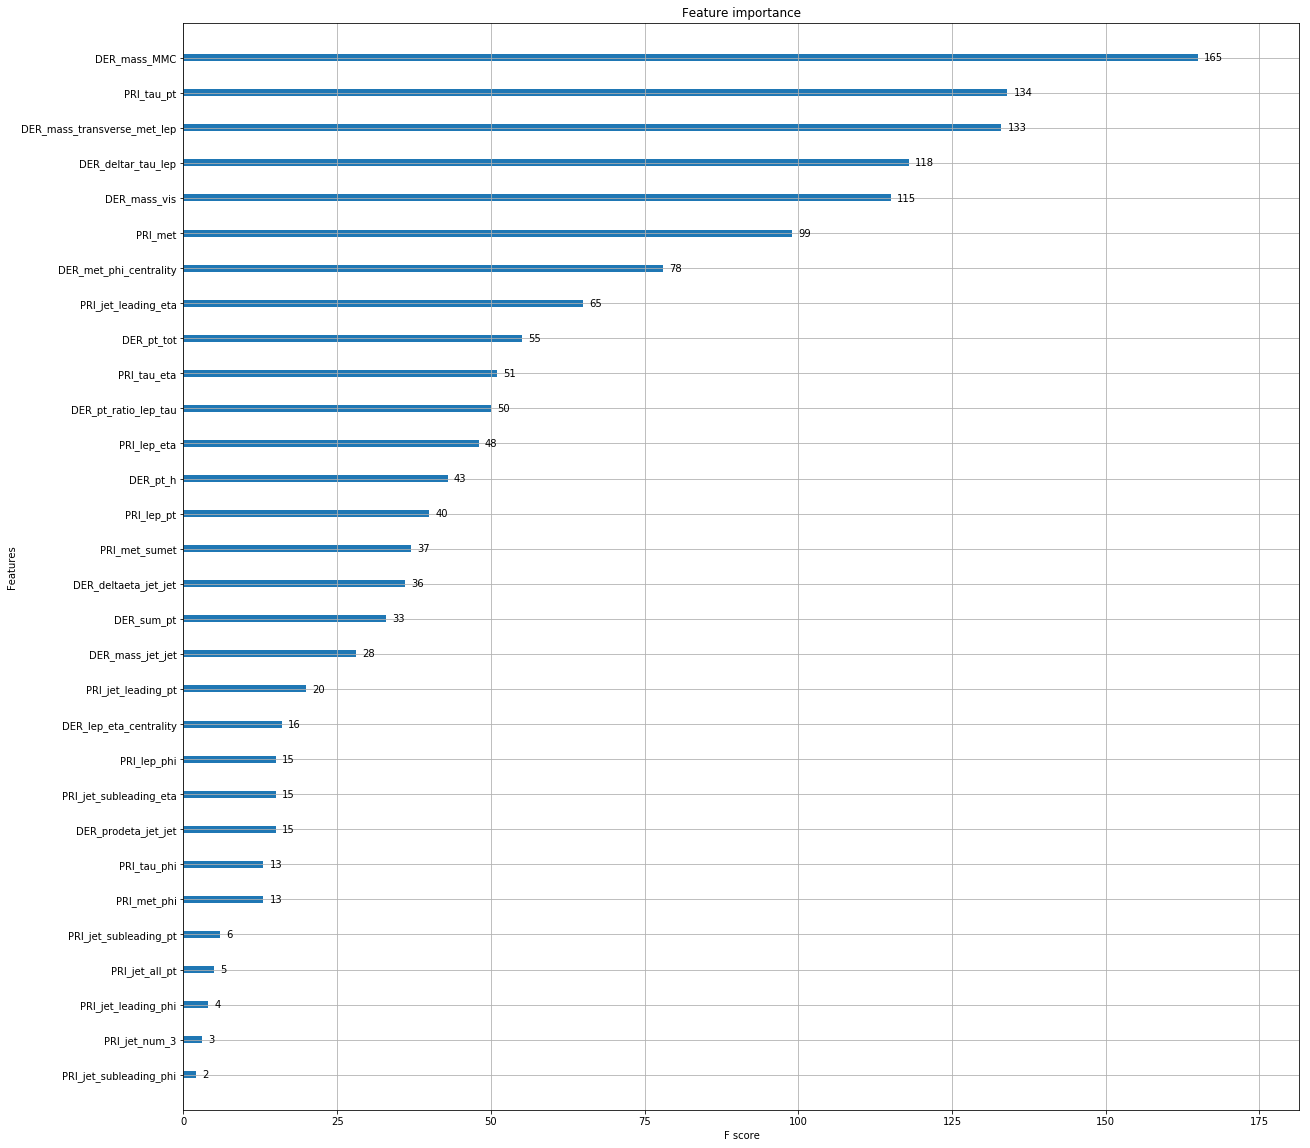

In [135]:
xgb.plot_importance(xg_model_weighted)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()